In [19]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt

import matplotlib.pyplot as plt
import seaborn as sns
import shapely

In [2]:
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.precision', 3)

# Lyft/Uber Traffic

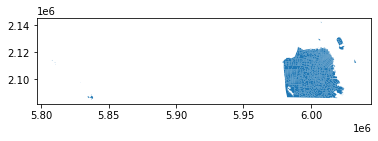

In [440]:
tnc_shape.plot()

In [106]:
tnc_shape = gpd.read_file('TNC shapefile/TAZ981.shp') 
tnc_geo = pd.DataFrame(tnc_shape)

remove = [305, 313, 384, 385, 865, 866, 867, 868, 869, 870, 871, 872]
tnc_geo = tnc_geo[~tnc_geo['TAZ'].isin(remove)]

tnc_flow = pd.read_csv('trip_stats_taz_0.csv').rename(columns={'taz':'TAZ'})
tnc_df = pd.DataFrame.merge(tnc_geo, tnc_flow, on='TAZ', how='right', sort=False)
tnc_df = tnc_df.dropna()
tnc_df = gpd.GeoDataFrame(tnc_df)

In [113]:
tnc_df.crs = tnc_shape.crs

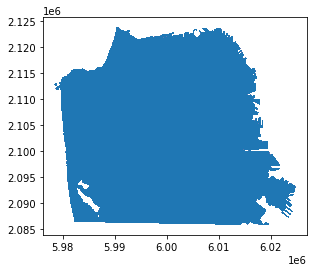

In [492]:
tnc_df.plot()

In [ ]:
tnc_df.loc[tnc_df['TAZ']==865].plot()

In [524]:
scaled = tnc_df.copy()
scaled['pickups'] = scaled['pickups'] * 100
scaled['dropoffs'] = scaled['dropoffs'] * 100

In [525]:
temp = scaled[scaled['day_of_week']==0].groupby(['TAZ','hour']).mean().reset_index()
temp

TAZ  hour  day_of_week  pickups  dropoffs
0        1     3            0     60.0      40.0
1        1     4            0      0.0      40.0
2        1     5            0     60.0      60.0
3        1     6            0     80.0     100.0
4        1     7            0     60.0      80.0
...    ...   ...          ...      ...       ...
23251  981    22            0   1120.0    1200.0
23252  981    23            0    600.0     680.0
23253  981    24            0    320.0     320.0
23254  981    25            0    220.0     220.0
23255  981    26            0     60.0     200.0

[23256 rows x 5 columns]

In [526]:
mask = temp[temp['hour']==17]
mask = pd.DataFrame.merge(mask, tnc_geo, on='TAZ', how='left', sort=False).reset_index().drop('index', axis=1)
mask = gpd.GeoDataFrame(mask)

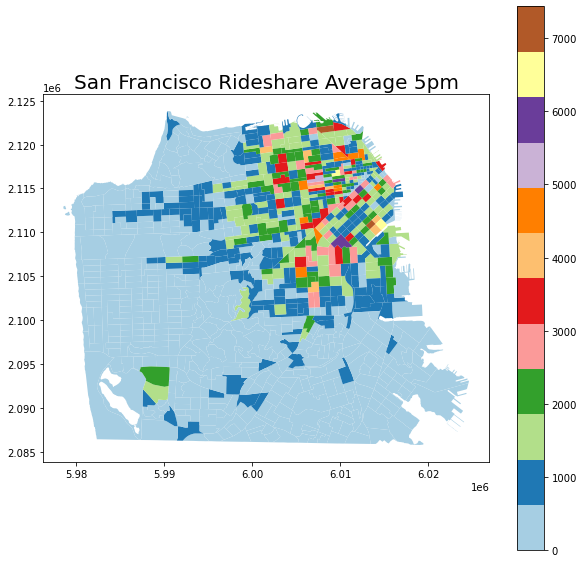

In [555]:
fig, ax = plt.subplots(figsize=(10,10))
mask.plot(column='pickups', ax=ax, legend=True, cmap='Paired')
plt.title('San Francisco Rideshare Average 5pm', fontsize=20)
fig.savefig('test.png', format='png')


In [27]:
sf = gpd.read_file(gplt.datasets.get_path('san_francisco'))

In [115]:
tnc_df2 = tnc_df.to_crs({'init': 'epsg:4326'})

/Applications/miniconda3/envs/metis/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


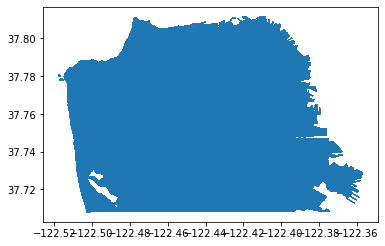

In [117]:
tnc_df2.plot()

In [13]:
sf2 = sf.to_crs({'proj': 'lcc',
 'lat_0': 36.5,
 'lon_0': -120.5,
 'lat_1': 37.0666666666667,
 'lat_2': 38.4333333333333,
 'x_0': 2000000,
 'y_0': 500000,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True})

/Applications/miniconda3/envs/metis/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


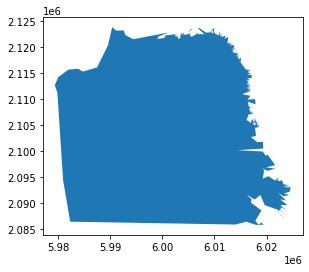

In [14]:
sf2.plot()

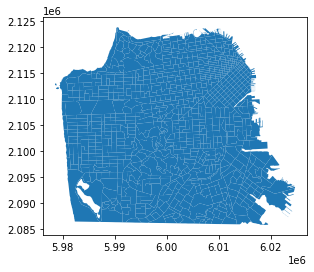

In [15]:
_ = gpd.GeoDataFrame(tnc_geo)
_.plot()

# Congestion

### Data Cleaning & EDA

In [3]:
import fiona
import shapely.geometry 
import json

In [4]:
congestion_file = fiona.open('TMC_SF_trushp_2017/TMC_SF_trushp.shp')

data_list=[]
for elmnt in congestion_file:
    data = {}
    data['id']=elmnt['id']
    data['TMC']=elmnt['properties']['TMC']
    data['street']=elmnt['properties']['street']
    data['direction']=elmnt['properties']['direction']
    data['intersection']=elmnt['properties']['intersec']
    try:
        data['geometry']=shapely.geometry.LineString(elmnt['geometry']['coordinates'])
    except ValueError:
        data['geometry']=None
    data_list.append(data)

congestion_geo=gpd.GeoDataFrame(data_list)
congestion_geo=congestion_geo.drop('id', axis=1)

In [5]:
congestion_geo.head(2)

TMC      street   direction         intersection  \
0  105-04871       I-280  SOUTHBOUND  18TH ST/MARIPOSA ST   
1  105-10307  GENEVA AVE   EASTBOUND           MISSION ST   

                                            geometry  
0  LINESTRING (-122.39614 37.76759, -122.39604 37...  
1  LINESTRING (-122.44230 37.71779, -122.44218 37...

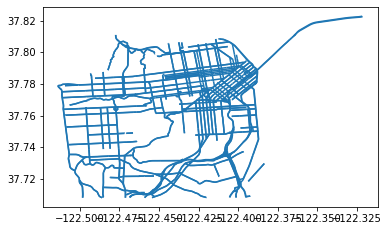

In [6]:
congestion_geo.plot()

In [7]:
traffic2016 = pd.read_csv("tncs_congestion_empirical_dataset/ESTFILE_2016.csv")
traffic2016 = traffic2016.drop('Unnamed: 0', axis=1)
traffic2016 = traffic2016.rename(columns= {'ModifiedTMC':'TMC'})

In [10]:
traffic2016.head()

ID        TMC TOD  YEAR  CHAMP_LINK_COUNT  PRESIDIO    PHF  \
0  105&10491_AM  105&10491  AM  2016                 2       0.0  0.348   
1  105&14211_AM  105&14211  AM  2016                 6       0.0  0.348   
2  105+04183_AM  105+04183  AM  2016                 1       0.0  0.348   
3  105+04184_AM  105+04184  AM  2016                 1       0.0  0.348   
4  105+04185_AM  105+04185  AM  2016                 1       0.0  0.348   

   ALPHA  BETA   AT  FT2  LANES  DISTANCE   CAPACITY     FFS  INRIX_SPEED  \
0   0.60   3.5  1.0    2    3.0     0.170   7758.621  28.467       18.089   
1   0.60   8.5  3.0    4    1.0     0.600   1374.521  25.215       16.903   
2   0.83   5.5  3.0    1    5.0     0.320  27298.851  69.380       43.508   
3   0.83   5.5  3.0    1    3.0     0.433  16379.310  71.580       43.253   
4   0.83   5.5  3.0    1    2.0     0.540  10057.471  71.490       43.362   

   SPEED_20TH  FF_TIME  INRIX_TIME  INRIX_VOL  CHAMP_PCE  CHAMP_VOL   TNC_VOL  \
0      10.484    0.358       0.564   7660.135   6320.849   5793.642   382.931   
1      14.950    1.428       2.130   1342.742    492.161    459.129    35.819   
2      20.980    0.277       0.441  25693.048  18463.779  17178.415  1498.757   
3      22.370    0.363       0.601  15688.794  14213.026  13337.149    23.859   
4      22.350    0.453       0.747   9616.635   4250.753   3841.266    13.499   

   TNC_PUDO  AVG_DUR  AVG_DUR_MAJOR_ARTERIALS  AVG_DUR_MINOR_ARTERIALS  \
0     9.325    2.331                    2.331                      0.0   
1     0.315    0.042                    0.000                      0.0   
2     0.000    0.000                    0.000                      0.0   
3     0.000    0.000                    0.000                      0.0   
4     0.000    0.000                    0.000                      0.0   

   BASE_INRIX_VOL_PRESIDIO  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0

In [11]:
congestion_geo.head(2)

TMC      street   direction         intersection  \
0  105-04871       I-280  SOUTHBOUND  18TH ST/MARIPOSA ST   
1  105-10307  GENEVA AVE   EASTBOUND           MISSION ST   

                                            geometry  
0  LINESTRING (-122.39614 37.76759, -122.39604 37...  
1  LINESTRING (-122.44230 37.71779, -122.44218 37...

In [12]:
#concatenation should give 7116 rows
print(traffic2016.shape)
print(congestion_geo.shape)

(7116, 28)
(2050, 5)


In [8]:
congestion_df=pd.merge(congestion_geo,traffic2016,on='TMC',how='right')
congestion=gpd.GeoDataFrame(congestion_df)

In [14]:
congestion.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7116 entries, 0 to 7115
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   TMC                      7116 non-null   object  
 1   street                   7006 non-null   object  
 2   direction                7006 non-null   object  
 3   intersection             7006 non-null   object  
 4   geometry                 7006 non-null   geometry
 5   ID                       7116 non-null   object  
 6   TOD                      7116 non-null   object  
 7   YEAR                     7116 non-null   int64   
 8   CHAMP_LINK_COUNT         7116 non-null   int64   
 9   PRESIDIO                 7116 non-null   float64 
 10  PHF                      7116 non-null   float64 
 11  ALPHA                    7116 non-null   float64 
 12  BETA                     7116 non-null   float64 
 13  AT                       7116 non-null   float64 
 14  

In [15]:
#sns.pairplot(congestion_df)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x22ac39680> (for post_execute):


KeyboardInterrupt: 

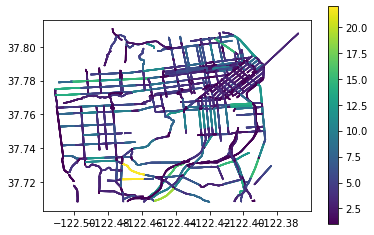

In [102]:
congestion.plot('CHAMP_LINK_COUNT', legend=True)

### Feature Engineering & Preprocessing

In [9]:
#DIRECTION: could be important to know bus routes
#TOD: needs to be turned into categorical
#TNC_PUDO: we dont care about how many pick up/drop offs there are - we just want to know how many tnc's are running through route
#INRIX_SPEED: avg speed is too influenced by travel during non-peak hours for each period
congestion_copy=pd.DataFrame(congestion.copy())
congestion_copy = congestion_copy.loc[:,['TMC', 'geometry', 'TOD', 'CHAMP_LINK_COUNT', 'PRESIDIO', 'PHF', 'AT',
                'FT2', 'CAPACITY', 'INRIX_VOL', 'TNC_VOL', 'LANES', 'FF_TIME', 'INRIX_TIME', 'AVG_DUR', 'DISTANCE']]

cap_per_hr = congestion_copy.loc[:,['TMC','CAPACITY']].groupby('TMC').sum().reset_index()
cap_per_hr['CAPACITY_PER_HOUR'] = cap_per_hr['CAPACITY']/24
cap_per_hr = cap_per_hr.drop('CAPACITY',axis=1)
modeling_data = congestion_copy.merge(cap_per_hr, on='TMC')

modeling_data['VOL_ADJ']=modeling_data['INRIX_VOL']**(1/(modeling_data['FT2']*3))
modeling_data['VOL_ADJ']=np.log(modeling_data['VOL_ADJ'])

modeling_data['INRIX_VOL']=np.log(modeling_data['INRIX_VOL'])
modeling_data['FF_TIME']=(modeling_data['FF_TIME']+1)**3


modeling_data['TNC_FLOW'] = (modeling_data['TNC_VOL']*modeling_data['PHF'])*360/modeling_data['CAPACITY_PER_HOUR']
modeling_data['TNC_FLOW_log'] = np.log(modeling_data['TNC_FLOW']+1)

modeling_data = pd.get_dummies(modeling_data, columns=['TOD'])

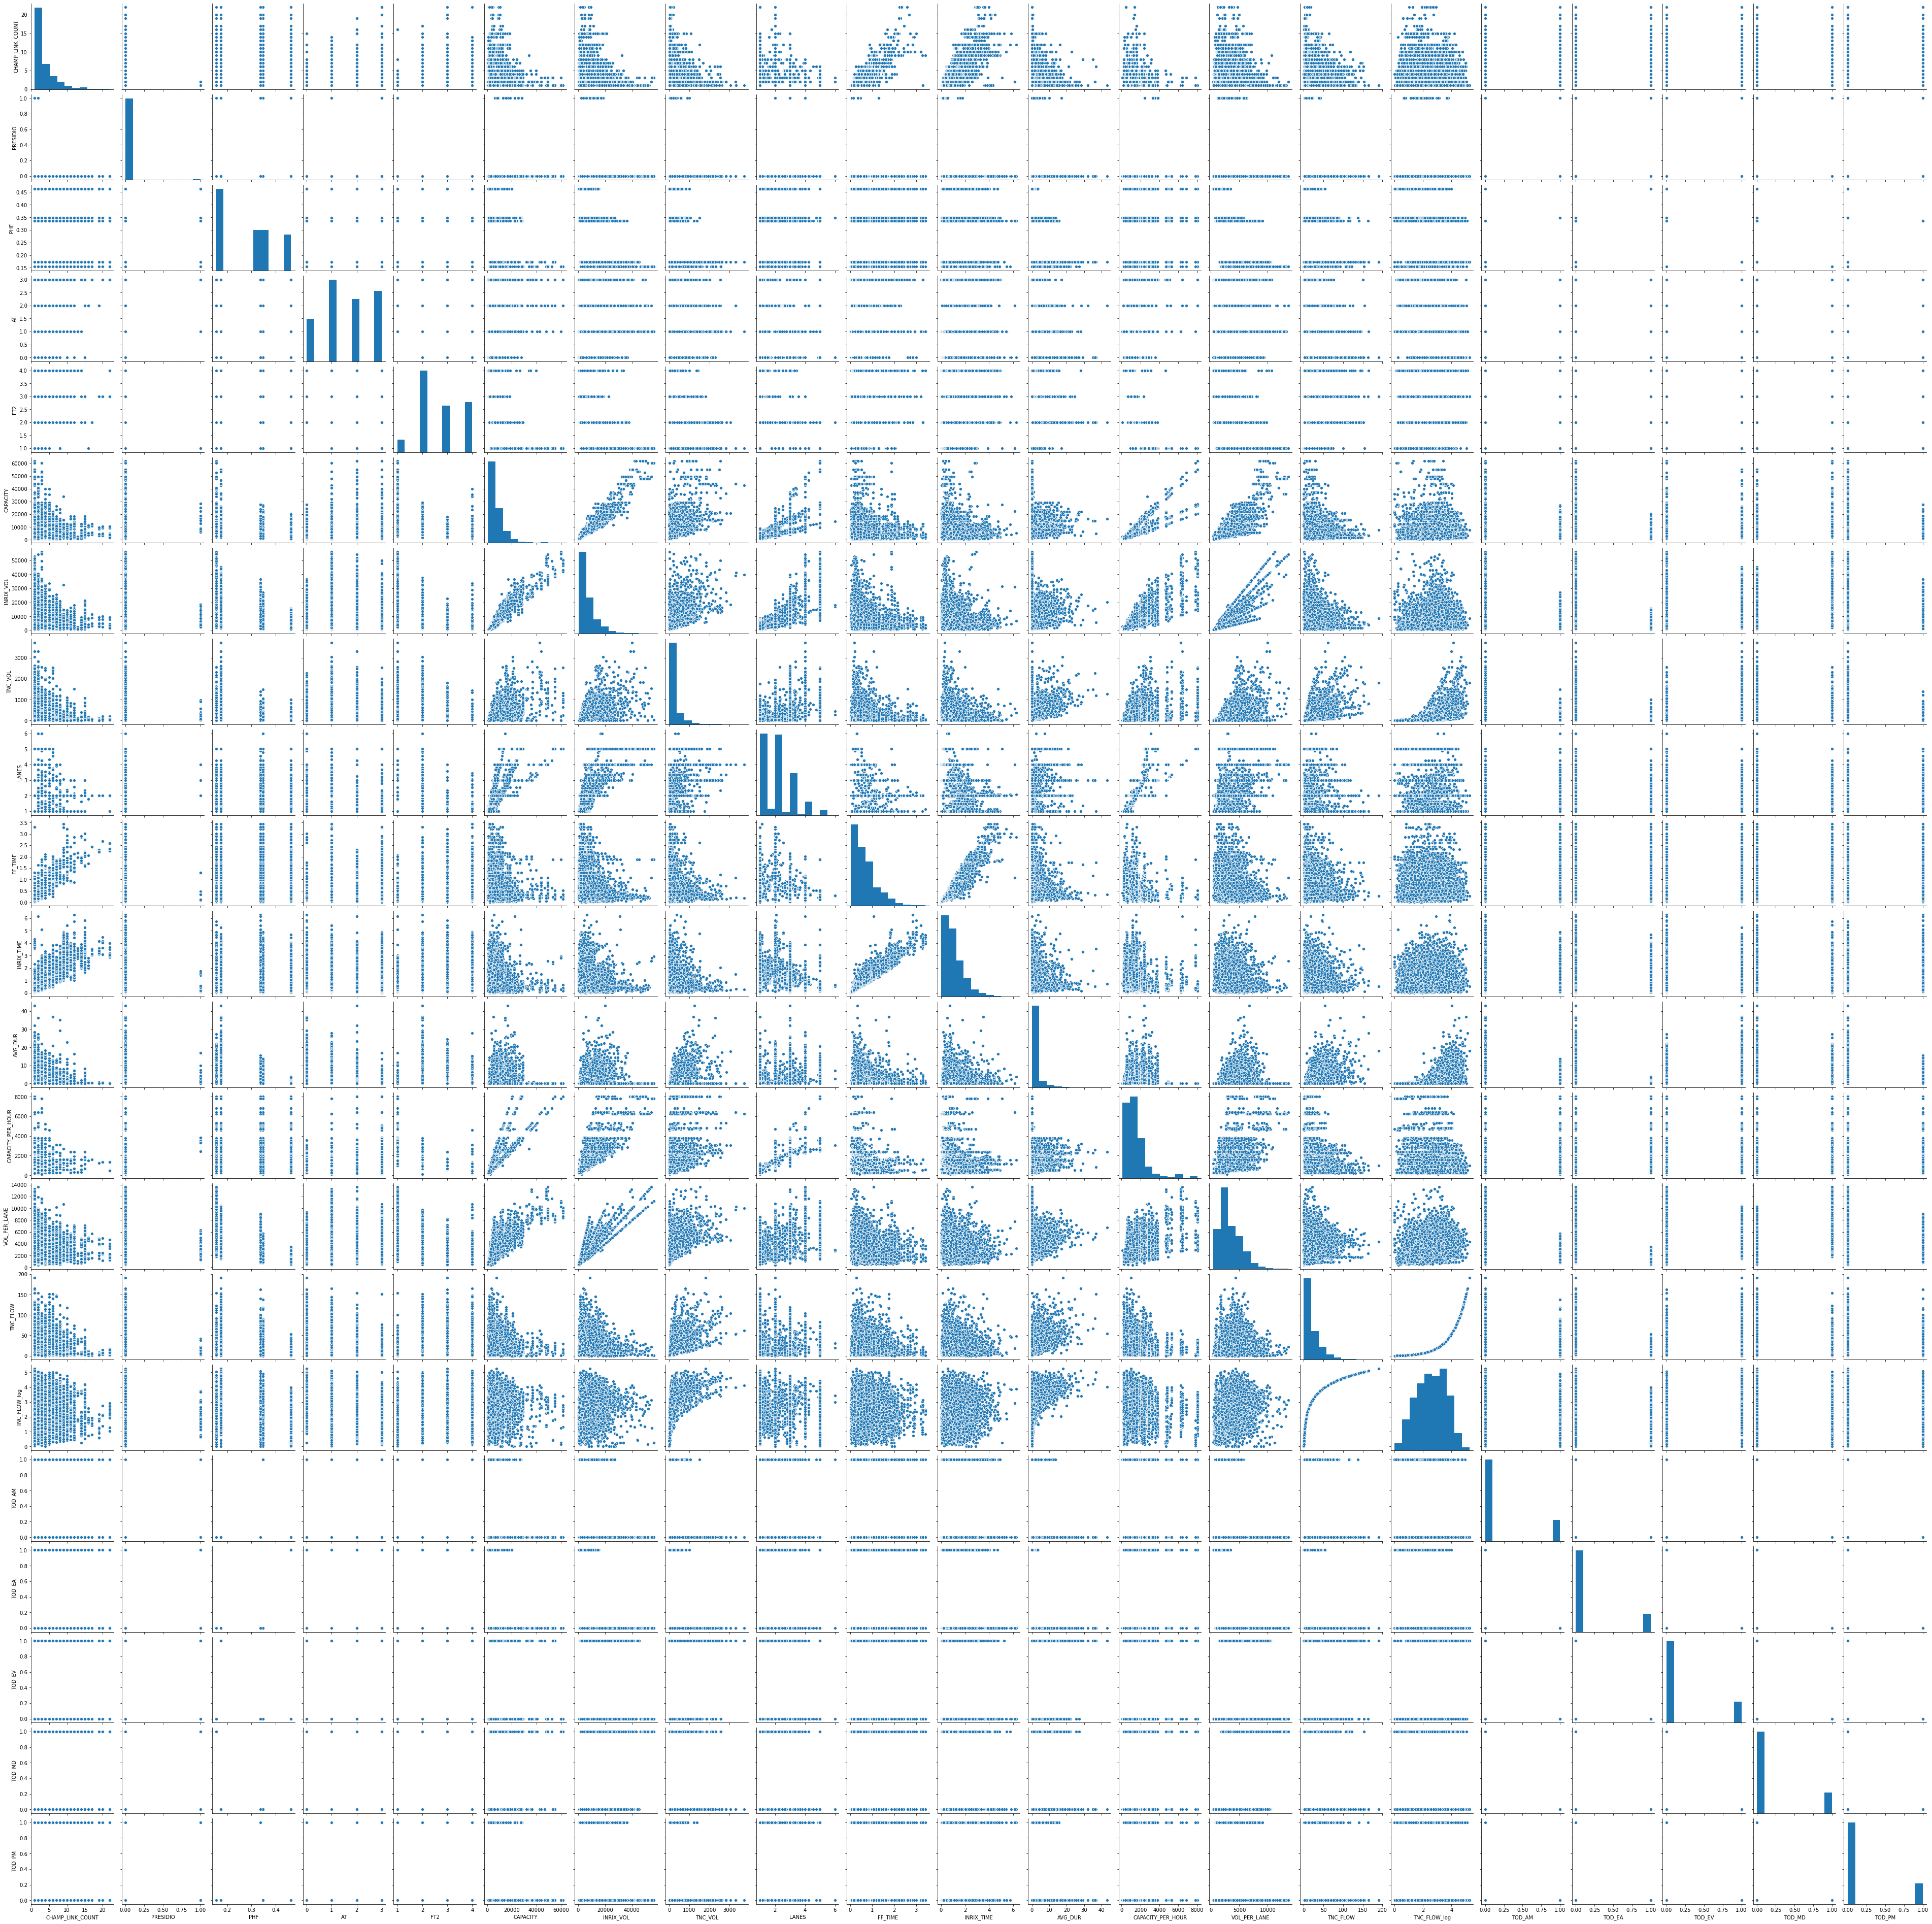

In [18]:
#sns.pairplot(modeling_data)

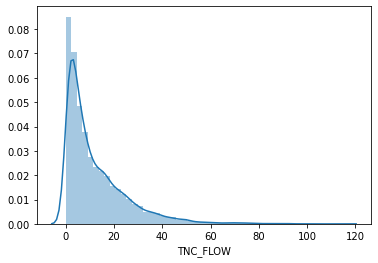

In [28]:
sns.distplot(modeling_data['TNC_FLOW']);

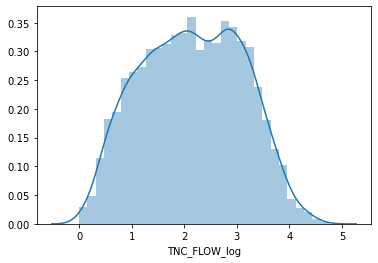

In [100]:
sns.distplot(modeling_data['TNC_FLOW_log']);

In [18]:
modeling_data.head(2)

TMC                                           geometry  \
0  105-04871  LINESTRING (-122.39614 37.76759, -122.39604 37...   
1  105-04871  LINESTRING (-122.39614 37.76759, -122.39604 37...   

   CHAMP_LINK_COUNT  PRESIDIO    PHF   AT  FT2   CAPACITY  INRIX_VOL  TNC_VOL  \
0                 1       0.0  0.348  2.0    1  21839.080      9.701  523.490   
1                 1       0.0  0.463  2.0    1  16414.687      9.458   80.454   

   LANES  FF_TIME  INRIX_TIME  AVG_DUR  DISTANCE  CAPACITY_PER_HOUR  VOL_ADJ  \
0    4.0    2.035       0.312      0.0      0.31           6420.291    3.234   
1    4.0    2.035       0.324      0.0      0.31           6420.291    3.153   

   TNC_FLOW  TNC_FLOW_log  TOD_AM  TOD_EA  TOD_EV  TOD_MD  TOD_PM  
0    10.215         2.417       1       0       0       0       0  
1     2.089         1.128       0       1       0       0       0

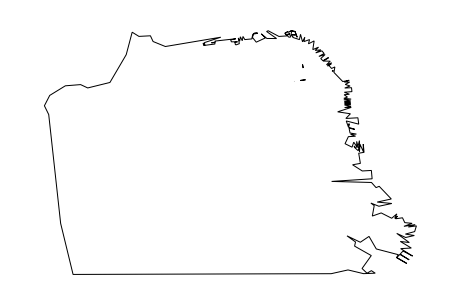

In [98]:
gplt.polyplot(sf)
plt.savefig('sf.svg', format='svg', transparent=True)

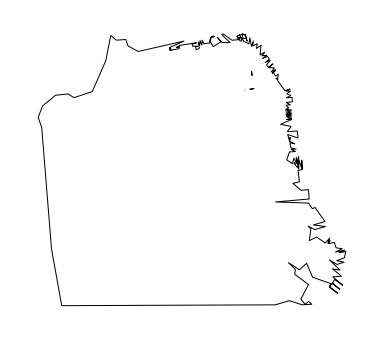

In [100]:
plot = gplt.polyplot(sf, projection=gcrs.AlbersEqualArea())
plot.plot()
plt.savefig('sf.svg', format='svg', transparent=True)

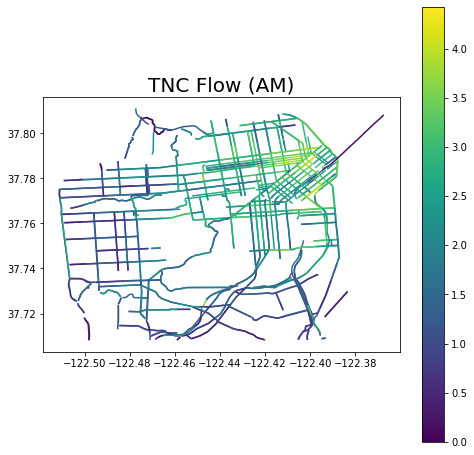

In [81]:
demo = gpd.GeoDataFrame(modeling_data)
#tnc_flow_demo = demo[demo['TOD_AM']==1]

demo[demo['TOD_AM']==1].plot(column='TNC_FLOW_log', legend=True, cmap='viridis', figsize=(8,8))

plt.title('TNC Flow (AM)', fontsize=20)
plt.savefig('tnc_flow.svg', format='svg', transparent=True)


### Modeling: Linear Regression

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [144]:
model = modeling_data.loc[:,['TNC_FLOW', 'INRIX_VOL', 'CHAMP_LINK_COUNT', 'AT', 'FT2', 'FF_TIME',
                         'TOD_AM', 'TOD_EV', 'TOD_MD', 'TOD_PM']]

In [145]:
#sns.pairplot(model)

In [102]:
selected_columns = ['AT', 'INRIX_VOL', 'TOD_AM', 'TOD_EV', 'TOD_MD', 'TOD_PM'] 
            #'CHAMP_LINK_COUNT', 'FT2', 'INRIX_VOL', 

In [103]:
X = modeling_data.loc[:,selected_columns]
y = modeling_data['TNC_FLOW_log']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=22)

## Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [107]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

def scores(model):
    r_squared = model.score(X,y)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    print('Train adj r^2: ' + str(adjusted_r_squared))

    y_predict = model.predict(X_test)
    r_squared = model.score(X_test, y_test)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Test adj r^2: ' + str(adjusted_r_squared))
    
    print('MAE: ' + str(mae(y_test, y_predict)))

In [108]:
#models

lm = LinearRegression()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=.01)

#simple validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')


#whole data simple regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

lm_reg = Ridge(alpha=.01)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')


scores(lm)

Linear Regression val R^2: 0.542
Ridge Regression val R^2: 0.542
Linear Regression test R^2: 0.530
Ridge Regression test R^2: 0.530
Train adj r^2: 0.5167927079135686
Test adj r^2: 0.5285004102266698
MAE: 0.5208660011564711


#### Cross Validation

In [109]:
#cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 12)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=100)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.4940432427050493, 0.5374953245387994, 0.4872584282726812, 0.5335147143516483, 0.5196663118149013]
Ridge scores:  [0.49304076813016584, 0.5318861348003063, 0.4894770842328703, 0.5297096978614558, 0.5187926474994553] 

Simple mean cv r^2: 0.514 +- 0.020
Ridge mean cv r^2: 0.513 +- 0.018


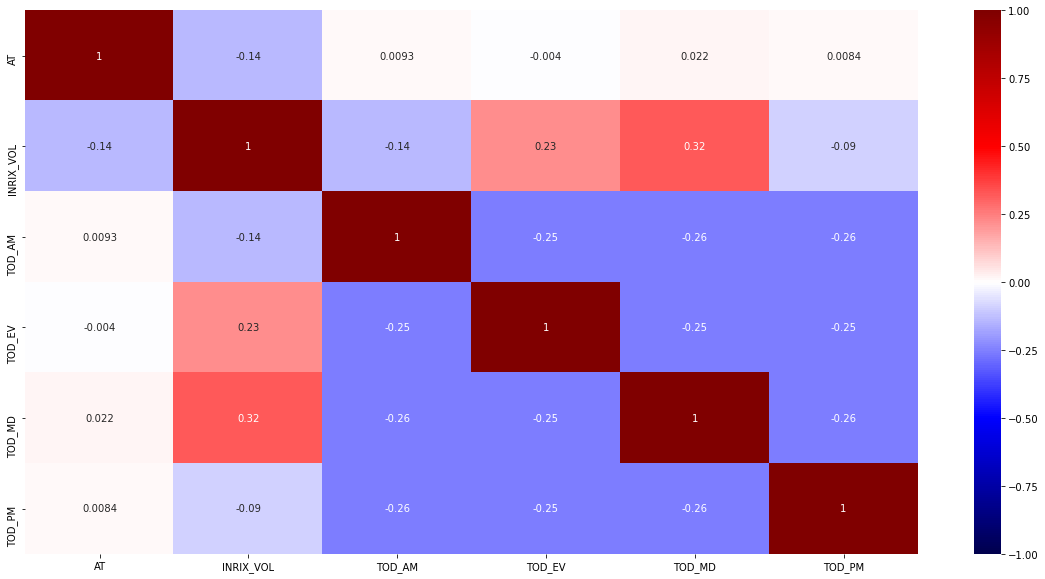

In [110]:
#modeling_data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(X.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

## MAE GRID SEARCH

In [111]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline 

In [112]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

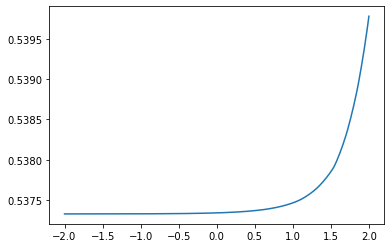

In [113]:
plt.plot(np.log10(alphalist), err_vec_val)

In [114]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried
print('minimum error achieved: ' ) 
print(np.min(err_vec_val))

## This is the value of alpha that gave us the lowest error
print('best alpha: ') 
print(alphalist[np.argmin(err_vec_val)])

minimum error achieved: 
0.5373266265300122
best alpha: 
0.01


In [115]:
mae_model = Ridge(alpha = .01)
mae_model.fit(X,y)
scores(mae_model)

Train adj r^2: 0.5168352849146737
Test adj r^2: 0.5285010514521064
MAE: 0.5208664284986294


## RIDGE

In [222]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lr_model_ridge = RidgeCV(alphas = alphavec, cv=5)
lr_model_ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [223]:
lr_model_ridge.alpha_

2.247805833548725

In [224]:
lr_model_ridge = Ridge(alpha = 2.247805833548725)
lr_model_ridge.fit(X_train_scaled, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('AT', -0.5236980177868836),
 ('FF_TIME', -0.0421109467086614),
 ('INRIX_VOL', -0.04435896124567335),
 ('TOD_AM', 0.3429044581302398),
 ('TOD_EV', 0.5902470223105831),
 ('TOD_MD', 0.3955425850106521),
 ('TOD_PM', 0.46231392213278705)]

In [225]:
lr_model_ridge.fit(X, y)

Ridge(alpha=2.247805833548725, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [243]:
scores(lr_model_ridge)

Train adj r^2: 0.5181249974801894
Test adj r^2: 0.5331532424742231
MAE: 0.5189782480588109


## LASSO

In [227]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lr_model_lasso = LassoCV(alphas = alphavec, cv=5)
lr_model_lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [228]:
lr_model_lasso.alpha_

0.01

In [229]:
lr_model_lasso = Lasso(alpha = .01)
lr_model_lasso.fit(X_train_scaled, y_train)

list(zip(X_train.columns, lr_model_lasso.coef_))

[('AT', -0.5081059289401729),
 ('FF_TIME', -0.0262709911360011),
 ('INRIX_VOL', -0.006501459777898482),
 ('TOD_AM', 0.2943632696148338),
 ('TOD_EV', 0.5309450382320825),
 ('TOD_MD', 0.3327209927535489),
 ('TOD_PM', 0.41210924976762386)]

In [244]:
lr_model_lasso.fit(X, y)
scores(lr_model_lasso)

Train adj r^2: 0.5049061330622167
Test adj r^2: 0.5228849114187011
MAE: 0.5289255701019131


In [300]:
import statsmodels.api as sm

In [303]:
model_lm = sm.OLS(y, sm.add_constant(X))
results = model_lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TNC_FLOW_log   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     875.9
Date:                Mon, 23 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:36:27   Log-Likelihood:                -5787.1
No. Observations:                5692   AIC:                         1.159e+04
Df Residuals:                    5684   BIC:                         1.164e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5417      0.103     24.696      0.000       2.340       2.744
AT            -0.5066      0.009    -59.040      0.000      -0.523      -0.490
FF_TIME       -0.0044      0.001     -4.166      0.000      -0.006      -0.002
INRIX_VOL     -0.0528      0.012     -4.348      0.000      -0.077      -0.029
TOD_AM         0.8493      0.029     29.466      0.000       0.793       0.906
TOD_EV         1.4589      0.031     47.059      0.000       1.398       1.520
TOD_MD         0.9784      0.032     30.778      0.000       0.916       1.041
TOD_PM         1.1363      0.029     39.163      0.000       1.079       1.193
==============================================================================
Omnibus:                       39.649   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.330
Skew:                          -0.201   Prob(JB):                     1.75e-09
Kurtosis:                       3.093   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## VIZ

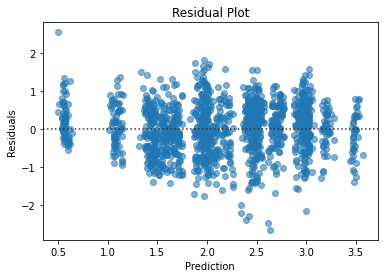

In [117]:
y_predict = mae_model.predict(X_test)
res = y_test - y_predict
ax = sns.residplot(y_predict, res, scatter_kws={'alpha':.57})
ax.set(title="Residual Plot" ,xlabel="Prediction", ylabel="Residuals")
plt.savefig("residuals.svg", transparent = True)

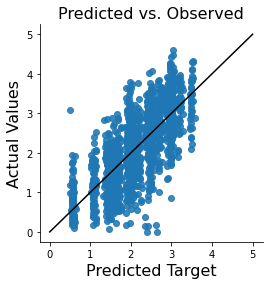

In [118]:
plt.figure(figsize=(4,4))
plt.scatter(y_predict, y_test, alpha=.87)
plt.plot(np.linspace(0,5,100), np.linspace(0,5,100), color = 'black')
plt.xlabel('Predicted Target', size=16)
sns.despine()
plt.ylabel('Actual Values', size=16)
plt.title('Predicted vs. Observed',
          size=16)
plt.savefig('pred_vs_actual.svg', format='svg', transparent=True)

In [124]:
columns = np.array(X.columns)
coefficients = np.array(mae_model.coef_)
coef_df = pd.DataFrame({'column': columns, 'coefficients': coefficients}, columns=['column', 'coefficients'])

columns_dict={'TOD_PM':'Afternoon', 'TOD_MD':'Midday', 'TOD_EV':'Evening', 'TOD_AM':'Morning', 
                       'INRIX_VOL':'Total Volume', 'FF_TIME':'Free Flow Time', 'AT':'Area Type'}
coef_df = coef_df.replace({'column':columns_dict})
coef_df['positive'] = coef_df['coefficients'] > 0
coef_df = coef_df.set_index('column')

In [130]:
coef_df

coefficients  positive
column                              
Area Type           -0.510     False
Total Volume        -0.043     False
Morning              0.846      True
Evening              1.450      True
Midday               0.967      True
Afternoon            1.132      True

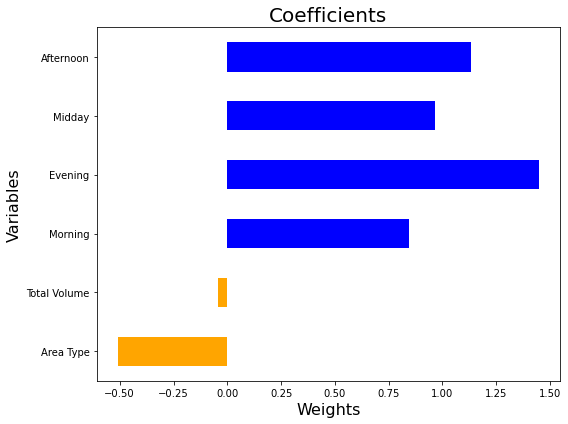

In [163]:
coef_df['coefficients'].plot(kind='barh', color=coef_df.positive.map({True: 'b', False: 'orange'}), figsize=(8,6))

plt.title('Coefficients', size=20)
plt.xlabel('Weights', size=16)
plt.ylabel('Variables', size=16)

#from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color='b', lw=4),
#                 Line2D([0], [0], color='orange', lw=4)]
# ax.legend(custom_lines, ['Cold', 'Medium'])

plt.tight_layout()
plt.savefig('coefficient.svg', transparent = True);

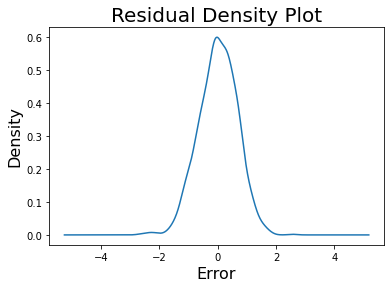

In [182]:
res.plot(kind='kde')
plt.xlabel('Error', size=16)
plt.ylabel('Density', size=16)
plt.title('Residual Density Plot', size=20)
plt.savefig('residual_kde.svg', transparent = True);

In [183]:
res.describe()

count    1424.000
mean        0.015
std         0.655
min        -2.641
25%        -0.414
50%         0.026
75%         0.473
max         2.572
Name: TNC_FLOW_log, dtype: float64